**Data-Driven Engineering Project: Prediction of a pendulum motion**

**Classification**

```
% Define constants
g = 9.81;                % acceleration due to gravity [m/s^2]
L = [0.1,0.5,1];           % length of pendulum [m]
M = [0.05,0.5,1];              % mass of pendulum [kg]
C = [0.001,0.05,0.01];     % damping coefficient [kg*m^2/s]
THETA0 = [25,50,75]./180*pi;    % initial angle [radians]
OMEGA0 = [0,0.5,1];                     % initial angular velocity [radians/s]
samples = 25;

mu = 0;
sigma = 0;
```

First we need to import in the datavectors X and Y from the .mat files


In [ ]:
from google.colab import files

# uploaded = files.upload() # upload directly but can take some time

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import scipy.io
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.integrate import odeint

X = scipy.io.loadmat('/content/gdrive/MyDrive/DataDrivenEngineering_Data/X.mat')
Y = scipy.io.loadmat('/content/gdrive/MyDrive/DataDrivenEngineering_Data/Y.mat')
Y = Y['Y'].T        # import the variable named 'Y' from the .mat file
X = X['X'].T

# Transpose to get the samples on the rows and features on columns

print(X.shape)
print(Y.shape)

(6075, 10001)
(6075, 5)


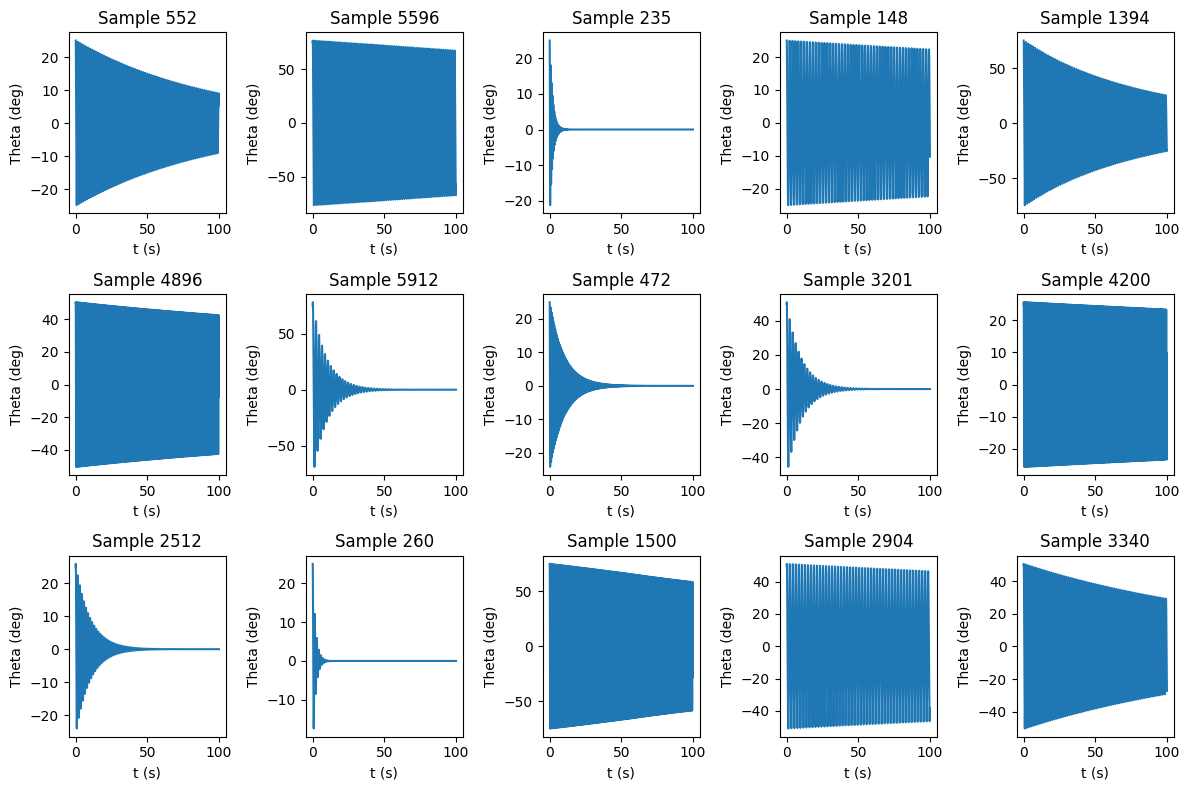

In [ ]:
# Plot some samples
def plot_obs(ax, i, X):  # pass the subplot ax as an argument
  dt = 0.01  # time step
  t_end = 100  # end time in seconds
  tspan = np.arange(0, t_end + dt, dt)

  ax.plot(tspan,X[i,:]*180/np.pi)
  ax.set_ylabel('Theta (deg)')
  ax.set_xlabel('t (s)')
  ax.set_title(f'Sample {i}')  # set a title for each subplot

# Making subplots
n_rows = 3
n_cols = 5

random_integers = np.random.randint(0, X.shape[0], size=n_cols*n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,8))  # create the subplots

for i, ax in enumerate(axs.flat):  # iterate over the subplots
  plot_obs(ax, random_integers[i], X)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()

In [ ]:
def value_to_label(Y):
    mapping = {}
    label = 0
    for length in [0.1, 0.5, 1]:
        for mass in [0.05, 0.5, 1]:
            for damping in [0.001, 0.05, 0.01]:
                for angle in np.radians([25, 50, 75]):
                    for angular_speed in [0, 0.5, 1]:
                        mapping[(length, mass, damping, angle, angular_speed)] = label
                        label += 1
    
    y_mapped = np.zeros(Y.shape[0])
    labels_length = Y[:,0] # Labels for length: [0.1, 0.5, 1]
    labels_mass = Y[:,1] # Labels for mass: [0.05, 0.5, 1]
    labels_damping = Y[:,2] # Labels for damping: [0.001, 0.05, 0.01]
    labels_angle = Y[:,3] # Labels for initial angle: [25, 50, 75] in radians!
    labels_angular_speed = Y[:,4] # Labels for initial angular speed: [0, 0.5, 1]
    
    for i in range(Y.shape[0]):
        if (labels_length[i], labels_mass[i], labels_damping[i], labels_angle[i], labels_angular_speed[i]) in mapping:
            y_mapped[i] = mapping[(labels_length[i], labels_mass[i], labels_damping[i], labels_angle[i], labels_angular_speed[i])]
    y_mapped = y_mapped.astype(int)
    return y_mapped

y_mapped = value_to_label(Y)
print(y_mapped.shape)

# Split the data into train and test sets and permutates randomly
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=5)

print(y_train[0:10])

# Scale the train and test parts
scaler = StandardScaler()
X0_train = scaler.fit_transform(X_train)
X0_test = scaler.transform(X_test)

# scaling and spliting cannot be interchanged because by scaling you use all of the data that you input, 
# such that you insert some knowledge of the test data!

(6075,)
[189 186  53 169 154  41 169  91 204  90]


In [ ]:
# Build a linear neural network using the tensorflow sequential model
# https://www.tensorflow.org/guide/keras/sequential_model

output_shape = 3*3*3*3*3 # possible combinations
input_shape = (X_train.shape[1],)

# Fully-connected neural network
model = tf.keras.Sequential([
    # # Let's start with input directly connected to output
    # tf.keras.layers.Dense(output_shape, input_shape=input_shape, activation='relu')

    # # Let's try adding 1 hidden layer
    # # Most logical choice is 5 parameters in the hidden layer bcs from physics we know described by five and then linear to output to make link with correct combination -> seems to give the BEST result (16% accuracy)
    # tf.keras.layers.Dense(5,input_shape=input_shape, name='Hidden1',activation = 'relu'), # First hidden Layer
    # tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')

    # # Let's try adding 2 hidden layers
    # # Always take the second to last layer 5 and linear to output (+16 first layer)-> gives about the same test accuracy as the 1 hidden layer (maybe even better?!) + 50epochs -> 19% test accuracy has been seen
    # tf.keras.layers.Dense(16,input_shape=input_shape, name='Hidden1',activation = 'relu'), # First hidden Layer
    # tf.keras.layers.Dense(5, activation="relu", name="Hidden2"), # Second hidden Layer
    # tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')

    # # Let's try adding 3 hidden layers
    # # Always take the second to last layer 5 and linear to output (+128 first layer + 16 second + 50epochs) -> 25% test accuracy has been seen
    # tf.keras.layers.Dense(128,input_shape=input_shape, name='Hidden1',activation = 'relu'), # First hidden Layer
    # tf.keras.layers.Dense(16, activation="relu", name="Hidden2"), # Second hidden Layer
    # tf.keras.layers.Dense(5, activation="relu", name="Hidden3"), # third hidden Layer
    # tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')

    # Let's try adding 4 hidden layers
    # Always take the second to last layer 5 and linear to output (+200 first layer + 128 second + 16 third+ 50epochs) -> % 26test accuracy has been seen
    tf.keras.layers.Dense(200,input_shape=input_shape, name='Hidden1',activation = 'relu'), # First hidden Layer
    tf.keras.layers.Dense(128, activation="relu", name="Hidden2"), # Second hidden Layer
    tf.keras.layers.Dense(16, activation="relu", name="Hidden3"), # Third hidden Layer
    tf.keras.layers.Dense(5, activation="relu", name="Hidden4"), # Fourth hidden Layer
    tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')
])

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 200)               2000400   
                                                                 
 Hidden2 (Dense)             (None, 128)               25728     
                                                                 
 Hidden3 (Dense)             (None, 16)                2064      
                                                                 
 Hidden4 (Dense)             (None, 5)                 85        
                                                                 
 Output (Dense)              (None, 243)               1458      
                                                                 
Total params: 2,029,735
Trainable params: 2,029,735
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X0_train, y_train, 
                    epochs=50, 
                    validation_data=(X0_test, y_test))

Epoch 1/50
152/152 [==============================] - 5s 10ms/step - loss: 5.0276 - accuracy: 0.0257 - val_loss: 4.4196 - val_accuracy: 0.0477
Epoch 2/50
152/152 [==============================] - 1s 5ms/step - loss: 4.0173 - accuracy: 0.0753 - val_loss: 3.6507 - val_accuracy: 0.1111
Epoch 3/50
152/152 [==============================] - 1s 6ms/step - loss: 3.3774 - accuracy: 0.1541 - val_loss: 3.1589 - val_accuracy: 0.2033
Epoch 4/50
152/152 [==============================] - 1s 7ms/step - loss: 2.9988 - accuracy: 0.2210 - val_loss: 2.9603 - val_accuracy: 0.2123
Epoch 5/50
152/152 [==============================] - 1s 6ms/step - loss: 2.8063 - accuracy: 0.2630 - val_loss: 2.6445 - val_accuracy: 0.3086
Epoch 6/50
152/152 [==============================] - 1s 7ms/step - loss: 2.4606 - accuracy: 0.3481 - val_loss: 2.4452 - val_accuracy: 0.3440
Epoch 7/50
152/152 [==============================] - 1s 5ms/step - loss: 2.3061 - accuracy: 0.3844 - val_loss: 2.3853 - val_accuracy: 0.3440
Epoch

38/38 - 0s - loss: 3.9412 - accuracy: 0.1761 - 102ms/epoch - 3ms/step
test loss: 3.941171646118164
test accuracy: 0.17613168060779572


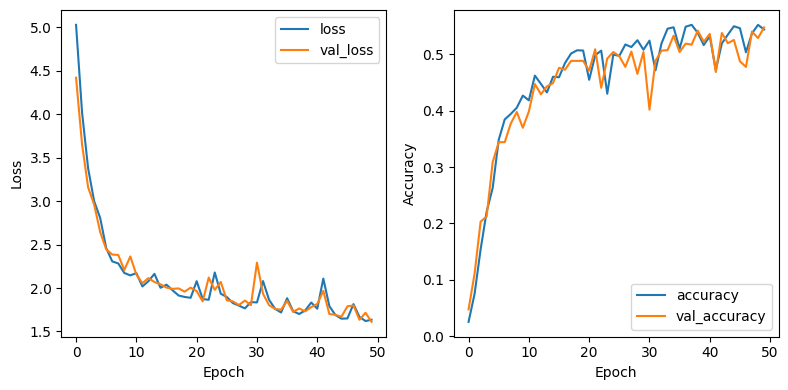

In [ ]:
# We can check the training history
# when the loss doesn't change anymore -> model has reached maximum accuracy
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label = 'val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

fig.tight_layout()
plt.show()

# graphs very important when training, loss can go down and val_loss can stay same
# model is getting overfit 
# select number of epochs on validation loss !!!

In [ ]:
# save the figure as an EPS file
fig.savefig('trainingHistory_ALL.eps', format='eps')
# download the figure to your local machine
from google.colab import files
files.download('trainingHistory_ALL.eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Add the softmax layer
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test) # predictions = (n_samples x n_features) with probability of prediction

38/38 [==============================] - 0s 3ms/step


In [ ]:
def label_to_values(label):
    # Define the possible values for each variable
    lengths = [0.1, 0.5, 1]
    masses = [0.05, 0.5, 1]
    dampings = [0.001, 0.05, 0.1]
    angles = [25, 50, 75]
    angular_speeds = [0, 0.5, 1]

    # Calculate the indices for each variable based on the label
    angular_speed_idx = int(label % 3)
    label //= 3
    angle_idx = int(label % 3)
    label //= 3
    damping_idx = int(label % 3)
    label //= 3
    mass_idx = int(label % 3)
    label //= 3
    length_idx = int(label)

    # Retrieve the values for each variable based on the calculated indices
    length = lengths[length_idx]
    mass = masses[mass_idx]
    damping = dampings[damping_idx]
    angle = angles[angle_idx] / 180 * np.pi
    angular_speed = angular_speeds[angular_speed_idx]

    return length, mass, damping, angle, angular_speed

# rand_index = np.random.randint(0, len(Y), size=1)
# Y_test = Y[rand_index[0]:rand_index[0]+1,:]
# print(Y_test)
# label = value_to_label(Y_test)
# print(label)
# values = label_to_values(label)
# print(values)


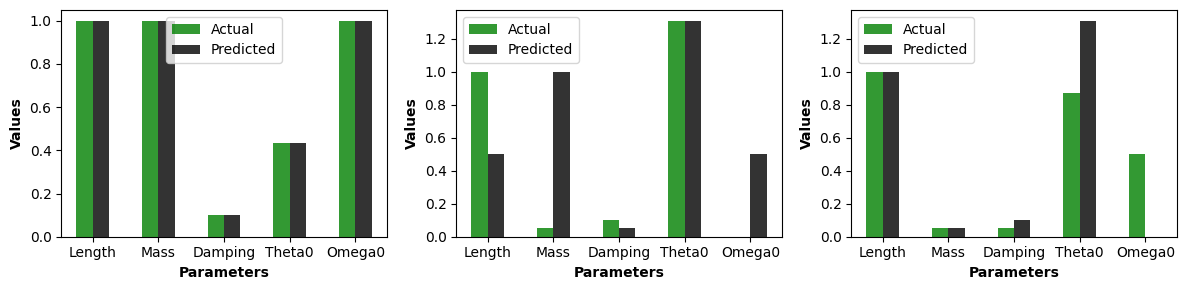

In [ ]:
def plot_pred(ax,i,predictions_array,true_label):
  pred_label = np.argmax(predictions_array[i,:])
  true_label = true_label[i]

  pred_length, pred_mass, pred_damping, pred_angle, pred_angular_speed = label_to_values(pred_label)
  true_length, true_mass, true_damping, true_angle, true_angular_speed = label_to_values(true_label)

  actual_values = [true_length, true_mass, true_damping, true_angle, true_angular_speed]
  predicted_values = [pred_length, pred_mass, pred_damping, pred_angle, pred_angular_speed]

  # # Create a bar plot
  # fig, ax = plt.subplots(figsize=(4, 2))

  index = [0, 1, 2, 3, 4]
  bar_width = 0.25
  opacity = 0.8

  rects1 = ax.bar(index, actual_values, bar_width,
                  alpha=opacity,
                  color='g',
                  label='Actual')

  rects2 = ax.bar([i + bar_width for i in index], predicted_values, bar_width,
                  alpha=opacity,
                  color='k',
                  label='Predicted')

  ax.set_xlabel('Parameters', fontweight='bold')
  ax.set_ylabel('Values', fontweight='bold')
  ax.set_xticks([i + bar_width / 2 for i in index])
  ax.set_xticklabels(('Length', 'Mass', 'Damping', 'Theta0', 'Omega0'))
  ax.legend()

  # plt.show()

# Making subplots
n_rows = 1
n_cols = 3

random_integers = np.random.randint(0, len(y_test), size=n_cols*n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,3))  # create the subplots

for i, ax in enumerate(axs.flat):  # iterate over the subplots
  plot_pred(ax, random_integers[i], predictions, y_test)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()
 

In [ ]:
# save the figure as an EPS file
fig.savefig('ClassificationALL.eps', format='eps')
# download the figure to your local machine
from google.colab import files
files.download('ClassificationALL.eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  Would be interesting to see what the accuracy is on each of the parameters -> maybe some parameters are easier to get right than others
count_L = 0
count_M = 0
count_C = 0
count_theta0 = 0
count_omega0 = 0
count_tot = len(y_test)

for i in range(len(y_test)):
  pred_length, pred_mass, pred_damping, pred_angle, pred_angular_speed = label_to_values(np.argmax(predictions[i,:]))
  true_length, true_mass, true_damping, true_angle, true_angular_speed = label_to_values(y_test[i])

  if pred_length == true_length:
    count_L += 1
  if pred_mass == true_mass:
    count_M += 1
  if pred_damping == true_damping:
    count_C += 1
  if pred_angle == true_angle:
    count_theta0 += 1
  if pred_angular_speed == true_angular_speed:
    count_omega0 += 1
print(f'The test accuracy: {round(test_acc*100,2)}')
print(f'The accuracy on the length is: {round(count_L/count_tot*100,2)}%, the mass: {round(count_M/count_tot*100,2)}%, the damping: {round(count_C/count_tot*100,2)}%, theta0: {round(count_theta0/count_tot*100,2)}% and omega0: {round(count_omega0/count_tot*100,2)}%')

The test accuracy: 28.15
The accuracy on the length is: 80.99%, the mass: 60.99%, the damping: 56.95%, theta0: 68.56% and omega0: 49.3%
